In [2]:
# ======================================
# 0. 기본 라이브러리
# ======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from bs4 import BeautifulSoup
import requests
import openpyxl
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import time
from selenium.webdriver.common.by  import By
from selenium.webdriver.common.keys import Keys

from pathlib import Path
import shutil
from datetime import datetime

import matplotlib.font_manager as fm
from matplotlib import rcParams


# ======================================
# 1. 스타일 먼저 (중요: 폰트보다 먼저)
# ======================================
plt.style.use('_mpl-gallery-nogrid')   # matplotlib 스타일
sns.set_theme(style="white")           # seaborn 기본 테마

# ======================================
# 2. 폰트 설정 (나눔고딕)
# ======================================
FONT_PATH = r"E:\seoul_pv_load_analysis\fonts\NanumGothic.ttf"

# matplotlib에 폰트 등록
fm.fontManager.addfont(FONT_PATH)

# 전역 폰트 지정
rcParams["font.family"] = "NanumGothic"

# 마이너스 깨짐 방지
rcParams["axes.unicode_minus"] = False

# (선택) 기본 폰트 사이즈 살짝 키우기
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# ======================================
# 3. 개별 객체용 폰트 (pie, title 등)
# ======================================
font_prop = fm.FontProperties(fname=FONT_PATH)

# ======================================
# 4. seaborn스타일 설정
# ======================================
sns.set_style("ticks") # 스타일 테마 설정
sns.set_context("notebook") # 문맥에 따라 스타일 크기 조정
sns.set_palette("pastel")

### DAY 2: 시간대별 전력 부하 구조 분석

**목적**
- 서울시 전력 수요가 하루 중 어떤 시간대에 집중되는지 확인

**주요 작업**
- USE_HM → hour 변환
- 시간대별 평균 전력 사용량 계산

**산출물**
- 서울시 평균 일간 전력 부하 곡선

In [ ]:
'''
DAY 2 목표:
시간대(hour) 기준으로 전력 부하의 분포와 피크 구조를 파악한다
(태양광/덕커브/요일/계절 확장은 오늘 하지 않는다)
'''

In [3]:
# 1. 경로 세팅 + DAY 1 결과 로드

# 1) 현재 위치
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_DIR = PROJECT_ROOT / "data"
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(exist_ok=True)

# 2) 원본 파일 경로
RAW_FILE = DATA_DIR / "법정동별시간별전력사용량.csv"

# 3) 파일 존재 확인
if not RAW_FILE.exists():
    raise FileNotFoundError(f"CSV 파일을 찾지 못함: {RAW_FILE}")

print("NOTEBOOK_DIR =", NOTEBOOK_DIR)
print("PROJECT_ROOT =", PROJECT_ROOT)
print("DATA_DIR =", DATA_DIR)
print("RAW_FILE =", RAW_FILE)

# 4) 인코딩 이슈 대비 로드
encodings_to_try = ["utf-8-sig", "cp949", "euc-kr"]

df_raw = None
last_error = None

for enc in encodings_to_try:
    try:
        df_raw = pd.read_csv(RAW_FILE, encoding = enc)
        print(f"로드 성공 (encoding = {enc})")
        break
    except Exception as e:
        last_error = e

if df_raw is None:
    raise RuntimeError(f"CSV 로드 실패, 마지막 에러: {last_error}")

print("행 / 열 =", df_raw.shape)
df_raw.head()

NOTEBOOK_DIR = e:\seoul_pv_load_analysis\notebooks
PROJECT_ROOT = e:\seoul_pv_load_analysis
DATA_DIR = e:\seoul_pv_load_analysis\data
RAW_FILE = e:\seoul_pv_load_analysis\data\법정동별시간별전력사용량.csv
로드 성공 (encoding = utf-8-sig)
행 / 열 = (9754804, 5)


,SIGUNGU_CD,BJDONG_CD,USE_YM,USE_HM,FDRCT_VLD_KWH
0,11650,10700,20220628,100,10782.0565
1,11650,10800,20220628,100,11394.8635
2,11650,10900,20220628,100,7273.9620
3,11740,10300,20220628,100,11008.8110
4,11710,11300,20220628,100,2905.1120


In [4]:
# 2. DAY 2 분석용 최소 테이블(df_base) 재구성

df = df_raw.copy()

# 1) 날짜 변환 (USE_YM: YYYYMMDD)
df["date"] = pd.to_datetime(df["USE_HM"], format = "%Y%m%d", errors = "coerce")

# 2) 시간(hour) 추출
# - USE_HM이 1 ~ 24 기준 (구간 종료 시각)이므로
# - 분석용 hour는 1시간 당겨서 0 ~ 23 으로 맞추기
df["hour"] = (df["USE_HM"]  // 100 - 1).astype("Int64")

# 3) datetime 생성
df["datetime"] = df["date"] + pd.to_timedelta(df["hour"].fillna(0), unit = "h")

# 4) value 생성 (전력사용량 수치화)
df["value"] = pd.to_numeric(df["FDRCT_VLD_KWH"].astype(str).str.replace(",",""), errors = "coerce")

# 5) 최소 테이블
df_base = df[["datetime", "hour", "value"]].copy()

# 6) 품질 체크 (금일 분석의 신뢰성 확보)
print("df_base 크기 =", df_base.shape)
print("hour 범위 =", df_base["hour"].min(), "~", df_base["hour"].max())
print("value 결측률(%) =", df_base["value"].isna().mean() * 100)

df_base.head()

df_base 크기 = (9754804, 3)
hour 범위 = 0 ~ 23
value 결측률(%) = 0.0


,datetime,hour,value
0,NaT,0,10782.0565
1,NaT,0,11394.8635
2,NaT,0,7273.9620
3,NaT,0,11008.8110
4,NaT,0,2905.1120


In [5]:
# 3. 시간대별 평균 부하(대표 패턴) 계산

# 1) hour (0 ~ 23) 기준으로 평균 전력 사용량 계산
hourly_mean = (df_base.groupby("hour", as_index = False)["value"].mean().sort_values("hour"))

# 2) 혹시 누락된 hour가 있으면 0 ~ 23을 채우기
all_hours = pd.DataFrame({"hour": np.arange(0, 24)})
hourly_mean = all_hours.merge(hourly_mean, on = "hour", how = "left")

print("시간대별 평균 테이블(상위 10행):")
hourly_mean.head(10)

시간대별 평균 테이블(상위 10행):


,hour,value
0,0,4828.966546
1,1,4436.061656
2,2,4301.931715
3,3,4069.172541
4,4,4467.956892
5,5,4570.492076
6,6,5000.093613
7,7,5677.409920
8,8,6575.992184
9,9,7246.801206


In [6]:
# 4. 피크 시간대 TOP3 확인

# value가 큰 순으로 TOP 3 시간대 확인
top3 = hourly_mean.sort_values("value", ascending = False).head(3)

print("피크 시간대 TOP 3 (hour, mean_value):")
display(top3)

# 피크 hour 하나도 뽑아두기
peak_hour = int(top3.iloc[0]["hour"])
print("최대 피크 시간대(대표) =", peak_hour, "시")

피크 시간대 TOP 3 (hour, mean_value):


,hour,value
13,13,7647.383917
12,12,7556.557942
11,11,7545.208877


최대 피크 시간대(대표) = 13 시


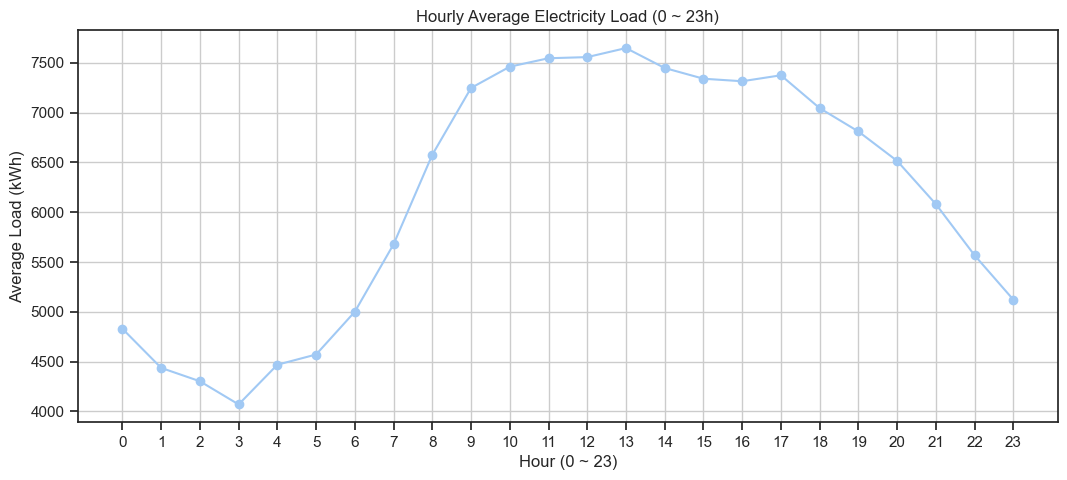

In [7]:
# 부하 곡선(그래프 1개) 생성

# 1) 그래프 그리기
plt.figure(figsize = (10, 4))
plt.plot(hourly_mean["hour"], hourly_mean["value"], marker = "o")

plt.title("Hourly Average Electricity Load (0 ~ 23h)")
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("Average Load (kWh)")
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.show()

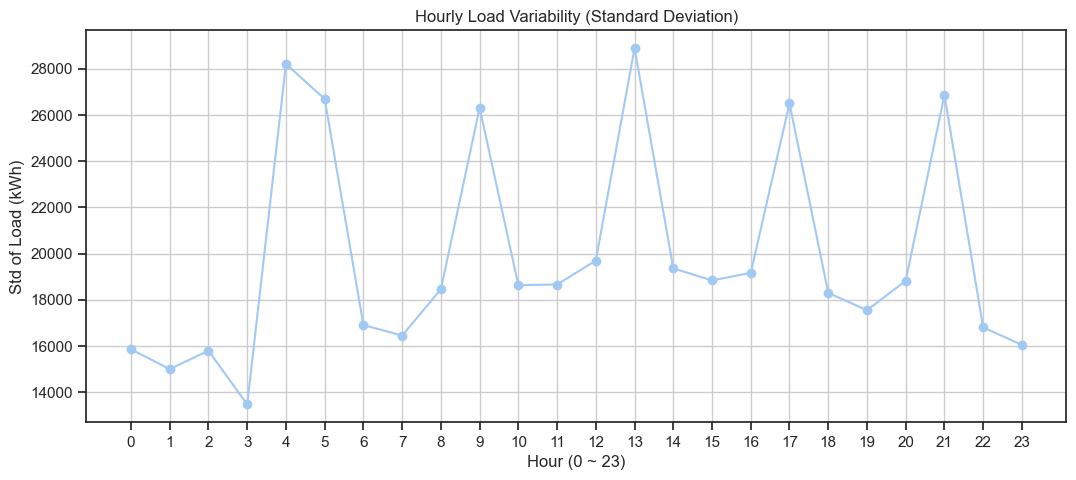

In [8]:
# 6. 변동성 / 분포 확인 - "평균만 보면 위험하지 않나" 방어용

# 시간대별 표준편차(변동성)도 같이 본다.
hourly_std = (df_base.groupby("hour", as_index = False)["value"].std().sort_values("hour"))
hourly_std = all_hours.merge(hourly_std, on = "hour", how = "left")

plt.figure(figsize = (10, 4))
plt.plot(hourly_std["hour"], hourly_std["value"], marker = "o")

plt.title("Hourly Load Variability (Standard Deviation)")
plt.xlabel("Hour (0 ~ 23)")
plt.ylabel("Std of Load (kWh)")
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.show()

In [9]:
# 7. DAY 2 Conclusion

print("===DAY 2 Conclusion===")
print(f"- 시간대(hour) 기준 평균 부하 곡선을 통해 전력 사용의 일중 분포를 확인")
print(f"- 대표 피크는 {peak_hour}시 전후에서 관측되며, 전력 사용이 특정 시간대에 집중하는 구조를 가진다.")
print("- 이 결과는 DAY 3의 태양광 이론 패턴과 비교하여 시간대 불일치를 해석하는 기준선으로 사용한다.")
print("- 특히 오후 후반 및 저녁 시간대에서는 부하 변동성 또한 크게 나타나, 단일 발전원 기반 대응의 한계를 시사한다.")

===DAY 2 Conclusion===
- 시간대(hour) 기준 평균 부하 곡선을 통해 전력 사용의 일중 분포를 확인
- 대표 피크는 13시 전후에서 관측되며, 전력 사용이 특정 시간대에 집중하는 구조를 가진다.
- 이 결과는 DAY 3의 태양광 이론 패턴과 비교하여 시간대 불일치를 해석하는 기준선으로 사용한다.
- 특히 오후 후반 및 저녁 시간대에서는 부하 변동성 또한 크게 나타나, 단일 발전원 기반 대응의 한계를 시사한다.


In [10]:
locals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', '_i2', 'np', 'pd', 'plt', 'sns', 'folium', 'BeautifulSoup', 'requests', 'openpyxl', 'webdriver', 'ChromeDriverManager', 'Service', 'time', 'By', 'Keys', 'Path', 'shutil', 'datetime', 'fm', 'rcParams', 'FONT_PATH', 'font_prop', '_i3', 'NOTEBOOK_DIR', 'PROJECT_ROOT', 'DATA_DIR', 'OUT_DIR', 'RAW_FILE', 'encodings_to_try', 'df_raw', 'last_error', 'enc', '_3', '_i4', 'df', 'df_base', '_4', '_i5', 'hourly_mean', 'all_hours', '_5', '_i6', 'top3', 'peak_hour', '_i7', '_i8', 'hourly_std', '_i9', '_i10'])

In [11]:
# Day 2 output: hourly average load profile
day2_out = hourly_mean.copy()

# 컬럼명 정리 (value → load_mean 인 경우 대비)
if "value" in day2_out.columns:
    day2_out = day2_out.rename(columns={"value": "load_mean"})

day2_out.to_csv(
    OUT_DIR / "DAY2_hourly_load_profile.csv",
    index=False,
    encoding="utf-8-sig"
)

print("Saved: outputs/DAY2_hourly_load_profile.csv")
day2_out.head()

Saved: outputs/DAY2_hourly_load_profile.csv


,hour,load_mean
0,0,4828.966546
1,1,4436.061656
2,2,4301.931715
3,3,4069.172541
4,4,4467.956892
